# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [67]:
ls ../eos/Jul21_2017/DYJetsToLL_Pt-100To250/outfiles/0-10_ele.parquet

../eos/Jul21_2017/DYJetsToLL_Pt-100To250/outfiles/0-10_ele.parquet


In [75]:
pd.read_parquet("../eos/Jul21_2017/DYJetsToLL_Pt-100To250/outfiles/0-10_ele.parquet")["weight_ele_pileupUp"]

0        548.287773
1        631.742648
2        750.001726
3      -1677.432822
4        521.886902
           ...     
9322    -100.804773
9323     608.131863
9324     746.203411
9325     363.071755
9326     575.339443
Name: weight_ele_pileupUp, Length: 9327, dtype: float64

In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
! ls ../eos/Jul21_2017

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [3]:
presel = {
    "mu": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",      

        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",        
    },
    "ele": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",

        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",     
        
        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",
        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [4]:
years = ["2017"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Jul21_"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
#     "Data"
]

In [5]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_tagger_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 36915 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4407 events
tot event weight 7835.774151845454 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 107849 events
---> Done with preselection.
Will fill the DYJets dataframe with the remaining 23063 events
tot event weight 23936.94799775357 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 1501 events
---> Done with preselection.
Will fill the VBF dataframe with the remaining 1426 events
tot event weight 4523.704524581752 

Finding HWminusJ_HToWW_M-125 samples 

---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 3853 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 3507 events
tot event weight 1162318.5523673492 

Finding GluGluZH_HToWW_ZTo2L_M-125 samples and should combine them under Diboson
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 10110 events
---> Done with preselection.
Will fill the Diboson dataframe with the remaining 9478 events
tot event weight 53.890988269899324 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 2520 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 1477 events
tot event weight 1618.5069463091986 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Using already stored event weight
---> Applying preselection.


---> Done with preselection.
Will fill the TTbar dataframe with the remaining 866757 events
tot event weight 249149431.95514217 

Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 2272344 events
---> Done with preselection.
Will fill the DYJets dataframe with the remaining 848637 events
tot event weight 6509251.126117596 

Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 73283 events
---> Done with preselection.
Will fill the SingleTop dataframe with the remaining 56496 events
tot event weight 4788024.271445281 

Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Using already stored event weight
---> App

---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 2113 events
---> Done with preselection.
Will fill the WZQQ dataframe with the remaining 1058 events
tot event weight 1807.3195355899586 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 2657 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 920 events
tot event weight 966.612118657353 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Using already stored event weight
---> Applying preselection.
applying lep_fj_dr selection on 243233 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 128874 events
tot event weight 201478.5138141319 

Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Using already stored event weight
---> Applying preselection.

In [6]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [7]:
events_dict["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [8]:
samples

['HWW',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson']

In [11]:
print("MUON CHANNEL")
mu_weights = []
for key in events_dict["2017"]["mu"]["WJetsLNu"].keys():
    if "weight_mu" in key and "Down" in key:
        print(key[:-4])
        mu_weights.append(key[:-4])
        
# print("ELECTRON CHANNEL")
# ele_weights = []
# for key in events_dict["2017"]["ele"]["WJetsLNu"].keys():
#     if "weight_ele" in key and "Down" in key:
#         print(key[:-4])
#         ele_weights.append(key[:-4])        

MUON CHANNEL
weight_mu_btagSFlight_correlated
weight_mu_isolation_muon
weight_mu_L1Prefiring
weight_mu_trigger_iso_muon
weight_mu_btagSFbc_correlated
weight_mu_d2K_NLO
weight_mu_btagSFlight_2017
weight_mu_W_d2kappa_EW
weight_mu_d1kappa_EW
weight_mu_W_d3kappa_EW
weight_mu_trigger_noniso_muon
weight_mu_btagSFbc_2017
weight_mu_id_muon
weight_mu_pileup
weight_mu_d1K_NLO
weight_mu_d3K_NLO


In [12]:
print("# of events with negative weights:")
for ch in ["mu", "ele"]:

    for year in years:
        for sample in samples:

            df = events_dict[year][ch][sample]

            print(ch, "channel", sample, (df[f"weight_{ch}"]<0).sum(), "out of", len(df[f"weight_{ch}"]), "events")

# of events with negative weights:
mu channel HWW 5 out of 17893 events
mu channel VH 1115 out of 62625 events
mu channel VBF 5 out of 1426 events
mu channel ttH 243 out of 10498 events
mu channel QCD 0 out of 8011 events
mu channel DYJets 143116 out of 461575 events
mu channel WJetsLNu 0 out of 984861 events
mu channel WZQQ 0 out of 4478 events
mu channel TTbar 15811 out of 1524322 events
mu channel SingleTop 18429 out of 185681 events
mu channel Diboson 0 out of 15726 events
ele channel HWW 2 out of 12596 events
ele channel VH 835 out of 49317 events
ele channel VBF 0 out of 921 events
ele channel ttH 229 out of 11238 events
ele channel QCD 0 out of 15660 events
ele channel DYJets 420496 out of 1392310 events
ele channel WJetsLNu 0 out of 732875 events
ele channel WZQQ 0 out of 7123 events
ele channel TTbar 16423 out of 1565946 events
ele channel SingleTop 12638 out of 131504 events
ele channel Diboson 0 out of 31358 events


In [10]:
events_dict[year][ch][sample]["lol"]

0       0.216724
6       0.216724
11      0.216724
21      0.216724
23      0.216724
          ...   
7706    0.145006
7711    0.145006
7714    0.145006
7715    0.145006
7723    0.145006
Name: lol, Length: 31358, dtype: float64

In [90]:
plt.rcParams.update({"font.size": 20})

ch = "ele"
var = "weight_mu_pileup"


# make histogram
h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),    
    hist2.axis.Regular(60, 0, 1, name="sys", label=var, overflow=True),
    hist2.axis.StrCategory([], name="variation", growth=True),
)    

for year in years:
    for sample in samples:

        if f"{var}Down" not in events_dict[year][ch][sample].keys():
            continue

        df = events_dict[year][ch][sample]

        h.fill(
            samples=sample,
            sys=df[f"{var}Down"],
            variation="Down"
        )

        h.fill(
            samples=sample,
            sys=df[f"{var}Up"],
            variation="Up"
        )        

        h.fill(
            samples=sample,
            sys=df[f"weight_mu"],
            variation="Nominal"
        )

sum of up counts: {}


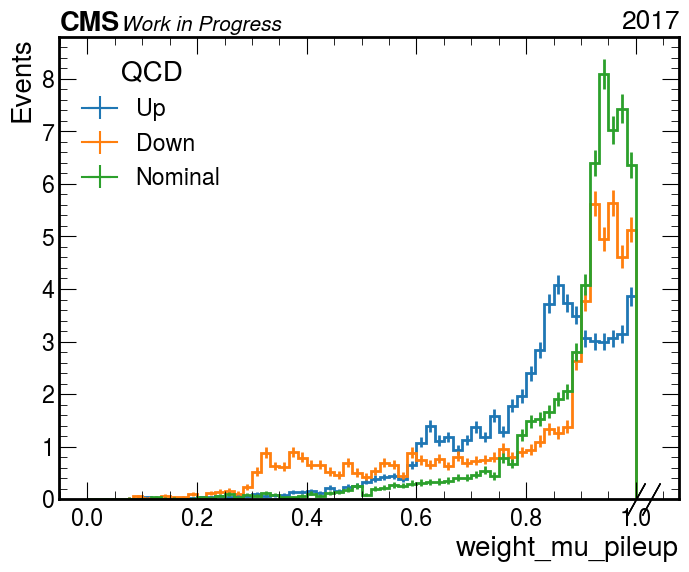

In [91]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "HWW"
sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"
# sample = "DYJets"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")


print("sum of up counts: {}")

In [83]:
h[{"samples": "DYJets", "variation": "Up"}].counts()

array([ 1697.,  1711.,  1698.,  1494.,  1437.,  1383.,  1328.,  1264.,
        1279.,  1306.,  1301.,  1241.,  1245.,  1103.,  1099.,   980.,
         983.,   891.,   887.,  1089.,  3041.,  5030.,  8628.,  8362.,
        5755.,  2951.,  1343.,  1121.,  2140., 30562., 79677.,  5108.,
        2625.,  3206.,  7455., 14133., 20563., 20851., 12151.,  7205.,
        2622.,  2032.,  1967.,  2218.,  2246.,  2503.,  2501.,  2734.,
        2886.,  2937.,  2905.,  2879.,  2811.,  3010.,  3170.,  3228.,
        3452.,  3650.,  3841.,  3798.])

In [84]:
            hep.histplot(
                h[{"samples": sample, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2dfdf6e20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

In [ ]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "HWW"
# sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")

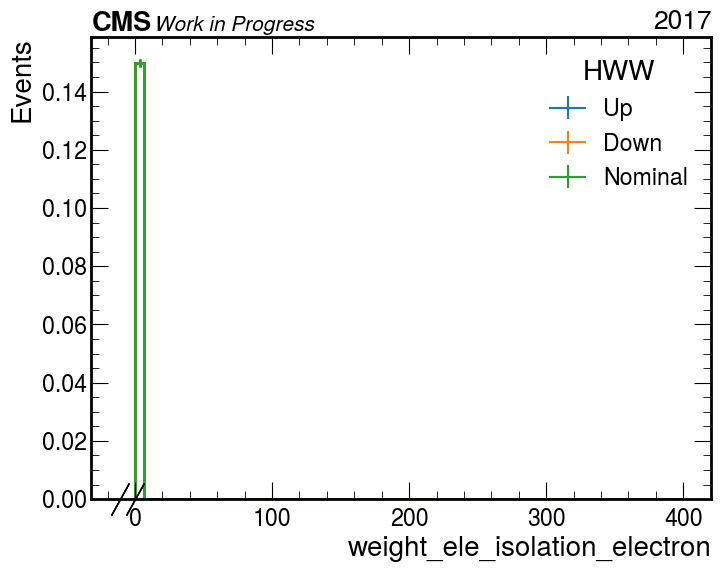

In [13]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "all"
sample = "HWW"
# sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")

# rec_higgs_m

In [630]:
print("MUON CHANNEL")
mu_weights = []
for key in events_dict["2017"]["mu"]["HWW"].keys():
    if "weight_mu" in key and "Down" in key:
        print(key[:-4])
        mu_weights.append(key[:-4])
        
# print("ELECTRON CHANNEL")
# ele_weights = []
# for key in events_dict["2017"]["ele"]["WJetsLNu"].keys():
#     if "weight_ele" in key and "Down" in key:
#         print(key[:-4])
#         ele_weights.append(key[:-4])        

MUON CHANNEL
weight_mu_btagSFbc_2017
weight_mu_pileup
weight_mu_PDFaS_weight
weight_mu_btagSFbc_correlated
weight_mu_trigger_iso_muon
weight_mu_UEPS_ISR
weight_mu_btagSFlight_2017
weight_mu_id_muon
weight_mu_UEPS_FSR
weight_mu_scalevar_3pt
weight_mu_L1Prefiring
weight_mu_isolation_muon
weight_mu_btagSFlight_correlated
weight_mu_aS_weight
weight_mu_trigger_noniso_muon
weight_mu_scalevar_7pt
weight_mu_PDF_weight


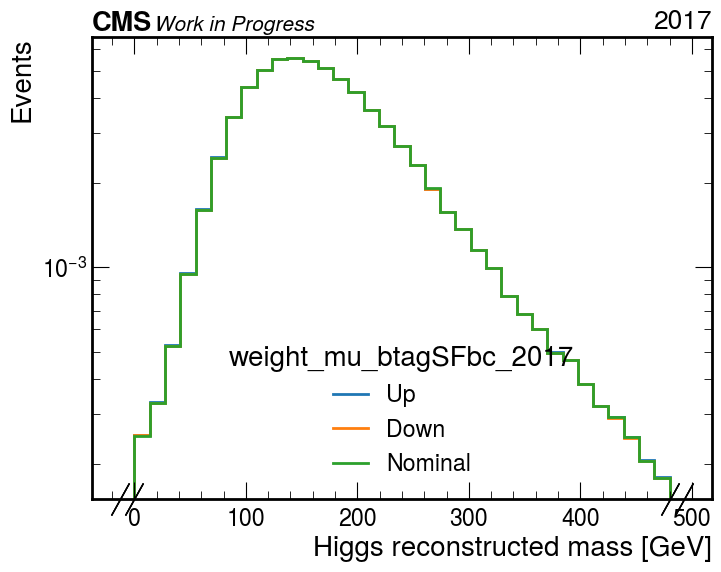

In [27]:
plt.rcParams.update({"font.size": 20})

var = "weight_mu_btagSFbc_2017"

# make histogram
h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    hist2.axis.StrCategory([], name="variation", growth=True),    
    hist2.axis.Regular(35, 0, 480, name="mass", label=r"Higgs reconstructed mass [GeV]", overflow=True)
)    

for year in years:
    for ch in ["mu"]:
        for sample in samples:
            
            if f"{var}Down" not in events_dict[year][ch][sample].keys():
                continue
            
            df = events_dict[year][ch][sample]

            h.fill(
                samples=sample,
                variation="Up",
                mass=df["rec_higgs_m"],
                weight=df[f"{var}Up"],
            )

            h.fill(
                samples=sample,
                variation="Down",
                mass=df["rec_higgs_m"],
                weight=df[f"{var}Down"],
            )

            h.fill(
                samples=sample,
                variation="Nominal",
                mass=df["rec_higgs_m"],
                weight=df[f"weight_{ch}"],
            )
            
# plot histogram




# for sample in ["HWW", "QCD", "WJetsLNu", "TTbar"]:
for sample in ["WJetsLNu"]:
    sample = "all"
    
    fig, ax = plt.subplots(figsize=(8, 6))    
    
    for variation in ["Up", "Down", "Nominal"]:

        if sample=="all":
            hep.histplot(
                h[{"samples": sum, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

        else:
            hep.histplot(
                h[{"samples": sample, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

    ax.legend(title=var) 
    if sample == "all":
        ax.legend(title=var)
        hep.cms.lumitext(
            "2017", ax=ax, fontsize=20
        )
    else:
        hep.cms.lumitext(
            sample + " - 2017", ax=ax, fontsize=20
        )      

    ax.set_ylabel("Events")
    plt.xlabel = var

    hep.cms.text("Work in Progress", ax=ax, fontsize=15);
    ax.set_yscale("log")
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics_v2/{var}.pdf")            

# Envelope

In [618]:
def shape_to_num(var, nom, clip=1.5):
    nom_rate = np.sum(nom)
    var_rate = np.sum(var)

    if abs(var_rate/nom_rate) > clip:
        var_rate = clip*nom_rate

    if var_rate < 0:
        var_rate = 0

    return var_rate/nom_rate

In [659]:
year = "2017"

weights = {
    
    "mu": {
        "all": [
            "weight_mu_btagSFlight_2017",
            "weight_mu_btagSFlight_correlated",
            "weight_mu_btagSFbc_2017",
            "weight_mu_btagSFbc_correlated",
            "weight_mu_pileup",
            "weight_mu_isolation_muon",
            "weight_mu_id_muon",
            "weight_mu_L1Prefiring",
            "weight_mu_trigger_iso_muon",
            "weight_mu_trigger_noniso_muon",            
        ],
        "WJetsLNu": [
            "weight_mu_d1K_NLO",
            "weight_mu_d2K_NLO",
            "weight_mu_d3K_NLO",
            "weight_mu_d1kappa_EW",
            "weight_mu_W_d2kappa_EW",
            "weight_mu_W_d3kappa_EW"
        ],
        "HWW": [
            "weight_mu_UEPS_FSR",
            "weight_mu_UEPS_ISR",
            "weight_mu_PDF_weight",
            "weight_mu_PDFaS_weight",
            "weight_mu_scalevar_3pt",
            "weight_mu_scalevar_7pt"
        ]
    },
    
    "ele": {
        "all": [
            "weight_ele_btagSFlight_2017",
            "weight_ele_btagSFlight_correlated",
            "weight_ele_btagSFbc_2017",
            "weight_ele_btagSFbc_correlated",
            "weight_ele_pileup",
            "weight_ele_isolation_electron",
            "weight_ele_id_electron",
            "weight_ele_L1Prefiring",
            "weight_ele_trigger_electron",
            "weight_ele_reco_electron"
        ],
        "WJetsLNu": [
            "weight_ele_d1K_NLO",
            "weight_ele_d2K_NLO",
            "weight_ele_d3K_NLO",
            "weight_ele_d1kappa_EW",
            "weight_ele_W_d2kappa_EW",
            "weight_ele_W_d3kappa_EW"
        ],
        "HWW": [
            "weight_ele_UEPS_FSR",
            "weight_ele_UEPS_ISR",
            "weight_ele_PDF_weight",
            "weight_ele_PDFaS_weight",
            "weight_ele_scalevar_3pt",
            "weight_ele_scalevar_7pt"
        ]
    },
}

In [774]:
norm_systematics = {
    "mu": [
            "weight_mu_btagSFlight_2017",
            "weight_mu_btagSFlight_correlated",
            "weight_mu_btagSFbc_2017",
            "weight_mu_btagSFbc_correlated",
            "weight_mu_isolation_muon",
            "weight_mu_id_muon",
            "weight_mu_L1Prefiring",
            "weight_mu_trigger_iso_muon",
            "weight_mu_trigger_noniso_muon",         
    ],
    "ele": [
            "weight_ele_btagSFlight_2017",
            "weight_ele_btagSFlight_correlated",
            "weight_ele_btagSFbc_2017",
            "weight_ele_btagSFbc_correlated",
            "weight_ele_isolation_electron",
            "weight_ele_id_electron",
            "weight_ele_L1Prefiring",
            "weight_ele_trigger_electron",
            "weight_ele_reco_electron"        
    ]
}

# MUON channel

In [748]:
import pickle as pkl
with open("/Users/fmokhtar/Desktop/hww/test/hists_templates.pkl", "rb") as f:
    hists_templates = pkl.load(f)

In [749]:
hists_templates

{'cat1_sr': Hist(
   StrCategory(['WJetsLNu', 'TTbar', 'HWW', 'QCD', 'Data'], growth=True, name='samples'),
   StrCategory(['Nominal', 'weight_mu_btagSFlight_2017Up', 'weight_mu_btagSFlight_2017Down', 'weight_mu_btagSFlight_correlatedUp', 'weight_mu_btagSFlight_correlatedDown', 'weight_mu_btagSFbc_2017Up', 'weight_mu_btagSFbc_2017Down', 'weight_mu_btagSFbc_correlatedUp', 'weight_mu_btagSFbc_correlatedDown', 'weight_mu_pileupUp', 'weight_mu_pileupDown', 'weight_mu_isolation_muonUp', 'weight_mu_isolation_muonDown', 'weight_mu_id_muonUp', 'weight_mu_id_muonDown', 'weight_mu_L1PrefiringUp', 'weight_mu_L1PrefiringDown', 'weight_mu_trigger_iso_muonUp', 'weight_mu_trigger_iso_muonDown', 'weight_mu_trigger_noniso_muonUp', 'weight_mu_trigger_noniso_muonDown', 'weight_mu_d1K_NLOUp', 'weight_mu_d1K_NLODown', 'weight_mu_d2K_NLOUp', 'weight_mu_d2K_NLODown', 'weight_mu_d3K_NLOUp', 'weight_mu_d3K_NLODown', 'weight_mu_d1kappa_EWUp', 'weight_mu_d1kappa_EWDown', 'weight_mu_W_d2kappa_EWUp', 'weight_mu_W_

In [751]:
for weight
hists_templates["cat1_sr"][{"samples": "TTbar", "fj_pt":sum, "systematic": "Nominal"}]

Hist(Variable([40, 61, 82, 103, 124, 145, 166, 187, 208, 229], name='rec_higgs_m', label='Higgs reconstructed mass [GeV]'), storage=Double()) # Sum: 8269085.147252883 (12288173.194868485 with flow)

In [788]:
norm_systematics_json = {}

ch = "mu"
for systematic in hists_templates["cat1_sr"].axes[1]:
    
    if "Up" in systematic:
        if systematic[:-2] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
            
            norm_systematics_json[systematic] = norm        

    elif "Down" in systematic:
        if systematic[:-4] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
            
            norm_systematics_json[systematic] = norm        

weight_mu_btagSFlight_2017Up: 1.0074279134165776
weight_mu_btagSFlight_2017Down: 0.9870638141541913
weight_mu_btagSFlight_correlatedUp: 1.0059360155274204
weight_mu_btagSFlight_correlatedDown: 0.9885730035614435
weight_mu_btagSFbc_2017Up: 1.0084557568927446
weight_mu_btagSFbc_2017Down: 0.9853050986973829
weight_mu_btagSFbc_correlatedUp: 1.0051590943758406
weight_mu_btagSFbc_correlatedDown: 0.9890074107614317
weight_mu_isolation_muonUp: 0.9969001548323311
weight_mu_isolation_muonDown: 0.9966775409589836
weight_mu_id_muonUp: 0.997743672920469
weight_mu_id_muonDown: 0.9958340228708451
weight_mu_L1PrefiringUp: 0.9879580087174192
weight_mu_L1PrefiringDown: 1.0055953315321364
weight_mu_trigger_iso_muonUp: 0.9969059771670048
weight_mu_trigger_iso_muonDown: 0.99667171862431
weight_mu_trigger_noniso_muonUp: 0.9978654520573604
weight_mu_trigger_noniso_muonDown: 0.9957122437339533


In [789]:
norm_systematics_json

{'weight_mu_btagSFlight_2017Up': 1.0074279134165776,
 'weight_mu_btagSFlight_2017Down': 0.9870638141541913,
 'weight_mu_btagSFlight_correlatedUp': 1.0059360155274204,
 'weight_mu_btagSFlight_correlatedDown': 0.9885730035614435,
 'weight_mu_btagSFbc_2017Up': 1.0084557568927446,
 'weight_mu_btagSFbc_2017Down': 0.9853050986973829,
 'weight_mu_btagSFbc_correlatedUp': 1.0051590943758406,
 'weight_mu_btagSFbc_correlatedDown': 0.9890074107614317,
 'weight_mu_isolation_muonUp': 0.9969001548323311,
 'weight_mu_isolation_muonDown': 0.9966775409589836,
 'weight_mu_id_muonUp': 0.997743672920469,
 'weight_mu_id_muonDown': 0.9958340228708451,
 'weight_mu_L1PrefiringUp': 0.9879580087174192,
 'weight_mu_L1PrefiringDown': 1.0055953315321364,
 'weight_mu_trigger_iso_muonUp': 0.9969059771670048,
 'weight_mu_trigger_iso_muonDown': 0.99667171862431,
 'weight_mu_trigger_noniso_muonUp': 0.9978654520573604,
 'weight_mu_trigger_noniso_muonDown': 0.9957122437339533}

In [790]:
import json
with open('mu_norm_systematics.json', 'w') as fp:
    json.dump(norm_systematics_json, fp)

In [791]:
! ls 

Feb7_build_tagger_inputs.ipynb         gen_matching_deep.ipynb
Feb7_matching_functions.ipynb          ggF_exploration.ipynb
Jul21_btag.ipynb                       ggh.root
Jul21_btagSF.ipynb                     hists_plots.ipynb
Jul21_rhalphalib.ipynb                 merged_file.root
Jul25_make_cards.ipynb                 mini-isolation.ipynb
July6_VBF_exploration.ipynb            mu_norm_systematics.json
July6_hists_plots_zll.ipynb            new.root
July6_regressed_mass.ipynb             old
July6_s_over_b.ipynb                   outfiles
July6_weights.ipynb                    outfiles2
June29_gen_matching.ipynb              processors.zip
README.md                              roc_curves.ipynb
Untitled.ipynb                         trigger_efficiency_plots.ipynb
check_signal_tth.ipynb                 trigger_efficiency_scale_factors.ipynb
coffea_playground.ipynb                triton_check.ipynb
cutflows.ipynb                         tt_matching_inference.ipynb
efficiencies        

In [785]:
ch = "ele"
for systematic in hists_templates["cat1_sr"].axes[1]:
    
    if "Up" in systematic:
        if systematic[:-2] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
    
    elif "Down" in systematic:
        if systematic[:-4] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")    